# Knowledge distillation on BoolQA

## Load libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import math
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import datasets
import transformers
datasets.logging.set_verbosity_error()
transformers.logging.set_verbosity_error()

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using transformers v{transformers.__version__} and datasets v{datasets.__version__}")
print(f"Running on device: {device}")

Using transformers v4.1.1 and datasets v1.2.0
Running on device: cuda


## Load and inspect data

In [ ]:
boolq = load_dataset("super_glue", "boolq")
boolq

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

In [ ]:
boolq.rename_column_("label", "labels")

In [ ]:
boolq['train'][0]

{'idx': 0,
 'labels': 1,
 'passage': 'Persian language -- Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.',
 'question': 'do iran and afghanistan speak the same language'}

In [ ]:
boolq.set_format('pandas')

In [ ]:
df = boolq['train'][:]
df.head()

,idx,label,passage,question
0,0,1,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",do iran and afghanistan speak the same language
1,1,1,Good Samaritan law -- Good Samaritan laws offe...,do good samaritan laws protect those who help ...
2,2,1,Windows Movie Maker -- Windows Movie Maker (fo...,is windows movie maker part of windows essentials
3,3,1,"Powdered sugar -- Powdered sugar, also called ...",is confectionary sugar the same as powdered sugar
4,4,0,The Elder Scrolls Online -- As with other game...,is elder scrolls online the same as skyrim


In [ ]:
df['input_len'] = (df['question'] + df['passage']).apply(lambda x: len(x.split(" ")))

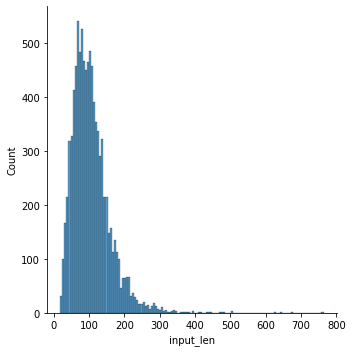

In [ ]:
import seaborn as sns

sns.displot(df['input_len'])

In [ ]:
df[(df['input_len'] > 512)]

,idx,label,passage,question,input_len
204,204,0,"Canada's Worst Driver -- In each season, eight...",does canada's worst driver lose their license,764
2352,2352,1,Brooke Davis -- She spends all of Valentine's ...,one tree hill episode brooke finds out she's p...,672
3547,3547,1,Lexie Grey -- After openly acknowledging the s...,do little grey and mark get back together,625
7410,7410,0,Out of My Mind (Draper novel) -- Melody Brooks...,does penny die in out of my mind,645


In [ ]:
df['label'].value_counts()

1    5874
0    3553
Name: label, dtype: int64

## Metrics

In [ ]:
accuracy_score = load_metric('accuracy')

In [ ]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

## Fine-tune BERT-large

In [ ]:
boolq.reset_format()

In [ ]:
bl_ckpt = "bert-large-uncased-whole-word-masking"
bl_tokenizer = AutoTokenizer.from_pretrained(bl_ckpt)

In [ ]:
def tokenize_and_encode(x, tokenizer): return tokenizer(x['question'], x['passage'], truncation="only_second")

boolq_enc = boolq.map(tokenize_and_encode, fn_kwargs={'tokenizer' : bl_tokenizer}, batched=True)

In [ ]:
bl_model = AutoModelForSequenceClassification.from_pretrained(bl_ckpt).to(device)

batch_size = 4
learning_rate = 2e-5
num_train_epochs = 3
logging_steps = len(boolq_enc['train']) // batch_size

args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_steps=logging_steps,
    disable_tqdm=False
)

bl_trainer = Trainer(
    args=args,
    model= bl_model,
    train_dataset=boolq_enc['train'],
    eval_dataset=boolq_enc['validation'],
    tokenizer=bl_tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# bl_trainer.evaluate()

In [ ]:
bl_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.659119,0.592962,0.692355
2,0.543818,0.778216,0.759021
3,0.281410,1.179402,0.787462


TrainOutput(global_step=7071, training_loss=0.49457359432438136)

In [ ]:
bl_trainer.save_model("models/bert-large-uncased-wwm-finetuned-boolq")

## Fine-tune BERT-base

In [ ]:
bb_ckpt = "bert-base-uncased"
bb_tokenizer = AutoTokenizer.from_pretrained(bb_ckpt)
bb_model = AutoModelForSequenceClassification.from_pretrained(bb_ckpt).to(device)

batch_size = 16
learning_rate = 2e-5
num_train_epochs = 3
logging_steps = len(boolq_enc['train']) // batch_size

args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_steps=logging_steps,
    disable_tqdm=False
)

trainer = Trainer(
    args=args,
    model= bb_model,
    train_dataset=boolq_enc['train'],
    eval_dataset=boolq_enc['validation'],
    tokenizer=bb_tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7349509596824646, 'eval_accuracy': 0.3798165137614679}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.651757,0.620844,0.661468
2,0.552436,0.575712,0.703670
3,0.414027,0.632376,0.713761


TrainOutput(global_step=1770, training_loss=0.539351423716141)

In [ ]:
trainer.save_model("models/bert-base-uncased-finetuned-boolq")

## Distill from BERT-large to BERT-base

The main thing we need to implement task-specific distillation is augment the standard cross-entropy loss with a distillation term (see above equation). We can implement this by overriding the `compute_loss` method of the `QuestionAnsweringTrainer`, but first let's define the training arguments we'll need:

In [ ]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha_ce=0.5, alpha_distil=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.alpha_ce = alpha_ce
        self.alpha_distil = alpha_distil
        self.temperature = temperature
        self.disable_tqdm = False

For the trainer, we'll need a few ingredients:

* We need two models (a teacher and student), and since the `model` attribute is the one that is optimized, we'll just add an attribute for the teacher
* When we pass the question and context to the student or teacher, we get a range of scores (logits) for the start and end positions. Since we want to minimize the distance between the teacher and student predictions , we'll use the KL-divergence as our distillation loss
* Once the distillation loss is computed, we take a linear combination with the cross-entropy to obtain our final loss function

The following code does the trick:

In [ ]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.teacher.eval()
        
    def compute_loss(self, model, inputs):
        inputs_stu = {
            "input_ids": inputs['input_ids'],
            "attention_mask": inputs['attention_mask'],
            "token_type_ids": inputs['token_type_ids'],
            "labels": inputs['labels']
            }
        outputs_stu = model(**inputs_stu)
        loss = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        with torch.no_grad():
            outputs_tea = self.teacher(
                input_ids=inputs["input_ids"], 
                token_type_ids=inputs["token_type_ids"],
                attention_mask=inputs["attention_mask"],
                labels=inputs["labels"])
            logits_tea = outputs_tea.logits
        assert logits_tea.size() == logits_stu.size()
        
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        loss = self.args.alpha_distil * loss_logits + self.args.alpha_ce * loss
        return loss

It's then a similar process to configure and initialise the trainer:

In [ ]:
batch_size = 16
logging_steps = len(boolq_enc['train']) // batch_size

student_training_args = DistillationTrainingArguments(
    output_dir=f"checkpoints",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=logging_steps,
)

In [ ]:
teacher_checkpoint = "lewtun/bert-base-uncased-finetuned-squad-v1"
student_checkpoint = "bert-base-uncased"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_checkpoint).to(device)
student_model = AutoModelForSequenceClassification.from_pretrained(student_checkpoint).to(device)
student_tokenizer = AutoTokenizer.from_pretrained(student_checkpoint)

distil_trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=boolq_enc['train'],
    eval_dataset=boolq_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer)

In [ ]:
# distil_trainer.evaluate()

In [ ]:
distil_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.340498,0.596097,0.716820
2,0.303301,0.564495,0.741896
3,0.271076,0.547016,0.755352


TrainOutput(global_step=1770, training_loss=0.3049012473747555)

In [ ]:
distil_trainer.save_model('models/bert-base-uncased-distilled-boolq')

## Speed test

As a simple benchmark, here we compare the time it takes for our teacher and student to generate 1,000 predictions on a CPU (to simulate a production environment). First, we load our fine-tuned models:

In [ ]:
student_model_ckpt = 'lewtun/bert-base-uncased-distilled-boolq'
teacher_model_ckpt = 'lewtun/bert-large-uncased-wwm-finetuned-boolq'

student_tokenizer = AutoTokenizer.from_pretrained(student_model_ckpt)
student_model = AutoModelForSequenceClassification.from_pretrained(student_model_ckpt).to('cpu')

teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_ckpt)
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_model_ckpt).to('cpu')

Next we create two pipelines for the student and teacher:

In [ ]:
student_pipe = QuestionAnsweringPipeline(student_model, student_tokenizer)
teacher_pipe = QuestionAnsweringPipeline(teacher_model, teacher_tokenizer)

And then run the inference test:

In [ ]:
%%time

for idx in range(1000):
    context = squad_ds['validation'][idx]['context']
    question = squad_ds['validation'][idx]['question']
    teacher_pipe(question=question, context=context)

CPU times: user 39min 55s, sys: 34.8 s, total: 40min 29s
Wall time: 6min 7s


In [ ]:
%%time

for idx in range(1000):
    context = squad_ds['validation'][idx]['context']
    question = squad_ds['validation'][idx]['question']
    student_pipe(question=question, context=context)

CPU times: user 19min 47s, sys: 13.3 s, total: 20min 1s
Wall time: 3min 1s


From this example, we see roughly a 2x speedup from using a distilled model with less than 3% drop in Exact Match / F1-score!